In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import librosa
from librosa.core import audio
import librosa.display
import IPython.display as  ipd
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [96]:
dir = "/Users/tainguyen/Library/CloudStorage/OneDrive-MichiganStateUniversity/Phuoc Tai Mastermind/Personal/Tai/Song_Data/fma_metadata"

## General Informations about the song

In [97]:
tracks = pd.read_csv(dir+"/tracks.csv",header=[0,1])
tracks.columns = tracks.columns.map('_'.join)
tracks.rename(columns={ tracks.columns[0]: "track_id" }, inplace = True)
tracks = tracks.iloc[1: , :]
print("shape of the tracks dataframe: ",str(tracks.shape))
tracks.head()

shape of the tracks dataframe:  (106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
1,2,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,4656.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293.0,NaN,3.0,NaN,[],Food
2,3,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,1470.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514.0,NaN,4.0,NaN,[],Electric Ave
3,5,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,1933.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151.0,NaN,6.0,NaN,[],This World
4,10,0.0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4.0,6.0,NaN,47632.0,NaN,...,NaN,54881.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135.0,NaN,1.0,NaN,[],Freeway
5,20,0.0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2.0,4.0,"<p> ""spiritual songs"" from Nicky Cook</p>",2710.0,NaN,...,NaN,978.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,361.0,NaN,3.0,NaN,[],Spiritual Level


In [98]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

There are total of 106574 songs with information about the album that song is in, the artist, and general information about the song like the release date and others. For the purpose of this project, I will only get the track_duration, track_genres, and track_title from this dataset.

In [99]:
tracks_features_of_interest = tracks[['track_id', 'set_subset', 'track_duration', 'track_genre_top', 'track_title']]
tracks_features_of_interest.head()

,track_id,set_subset,track_duration,track_genre_top,track_title
1,2,small,168.0,Hip-Hop,Food
2,3,medium,237.0,Hip-Hop,Electric Ave
3,5,small,206.0,Hip-Hop,This World
4,10,small,161.0,Pop,Freeway
5,20,large,311.0,NaN,Spiritual Level


## Features from Librosa

In [100]:
features = pd.read_csv(dir+"/features.csv", header=[0,1,2])
features.columns = features.columns.map('_'.join)
features.rename(columns={ features.columns[0]: "track_id" }, inplace = True)
features = features.iloc[1: , :]
print("shape of the tracks dataframe: ",str(features.shape))
features.head()

shape of the tracks dataframe:  (106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
1,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
2,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
3,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
4,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
5,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [101]:
features.columns

Index(['track_id', 'chroma_cens_kurtosis_01', 'chroma_cens_kurtosis_02',
       'chroma_cens_kurtosis_03', 'chroma_cens_kurtosis_04',
       'chroma_cens_kurtosis_05', 'chroma_cens_kurtosis_06',
       'chroma_cens_kurtosis_07', 'chroma_cens_kurtosis_08',
       'chroma_cens_kurtosis_09',
       ...
       'tonnetz_std_04', 'tonnetz_std_05', 'tonnetz_std_06', 'zcr_kurtosis_01',
       'zcr_max_01', 'zcr_mean_01', 'zcr_median_01', 'zcr_min_01',
       'zcr_skew_01', 'zcr_std_01'],
      dtype='object', length=519)

## Features from Echonest (Spotify)

In [102]:
echonest = pd.read_csv(dir+"/echonest.csv", header=[0,1,2])
echonest.columns = echonest.columns.map('_'.join)
echonest.rename(columns={ echonest.columns[0]: "track_id" }, inplace = True)
echonest = echonest.iloc[1: , :]
#echonest.columns = [col.replace('_', ' ') for col in echonest.columns]
print("shape of the echonest dataframe: ",str(echonest.shape))
echonest.head()

shape of the echonest dataframe:  (13129, 250)


,track_id,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence,echonest_metadata_album_date,...,echonest_temporal_features_214,echonest_temporal_features_215,echonest_temporal_features_216,echonest_temporal_features_217,echonest_temporal_features_218,echonest_temporal_features_219,echonest_temporal_features_220,echonest_temporal_features_221,echonest_temporal_features_222,echonest_temporal_features_223
1,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
2,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
3,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
4,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
5,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [103]:
echonest.columns

Index(['track_id', 'echonest_audio_features_acousticness',
       'echonest_audio_features_danceability',
       'echonest_audio_features_energy',
       'echonest_audio_features_instrumentalness',
       'echonest_audio_features_liveness',
       'echonest_audio_features_speechiness', 'echonest_audio_features_tempo',
       'echonest_audio_features_valence', 'echonest_metadata_album_date',
       ...
       'echonest_temporal_features_214', 'echonest_temporal_features_215',
       'echonest_temporal_features_216', 'echonest_temporal_features_217',
       'echonest_temporal_features_218', 'echonest_temporal_features_219',
       'echonest_temporal_features_220', 'echonest_temporal_features_221',
       'echonest_temporal_features_222', 'echonest_temporal_features_223'],
      dtype='object', length=250)

In [104]:
features_of_interest = ('track_id','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence')
echonest_features_of_interest = echonest.loc[:, echonest.columns.str.endswith(features_of_interest)]
echonest_features_of_interest.head()

,track_id,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence
1,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
2,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
3,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
4,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
5,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


We will explore the classification of song genre using features from Librosa, features from Echonest, and both features combine to see which features are more powerful to predict the genre of the song.

## Classification Using Features From Librosa

Let take a look at which genre are available for the features extracted from Librosa

In [123]:
data_lib = pd.merge(tracks_features_of_interest,
                    features, how='inner', on='track_id')
del data_lib['set_subset']
del data_lib['track_title']
print("The shape of data_lib is: ",str(data_lib.shape))
print(f"There are total of {str(data_lib['track_genre_top'].nunique())} genres available")
print("Available Genres are: ", data_lib['track_genre_top'].unique())

The shape of data_lib is:  (91214, 521)
There are total of 16 genres available
Available Genre are:  ['Hip-Hop' 'Pop' nan 'Rock' 'Experimental' 'Folk' 'Jazz' 'Electronic'
 'Spoken' 'International' 'Soul-RnB' 'Blues' 'Instrumental' 'Classical'
 'Easy Listening' 'Old-Time / Historic' 'Country']


Take a look at the distribution of songs among the 16 genres

<AxesSubplot:>

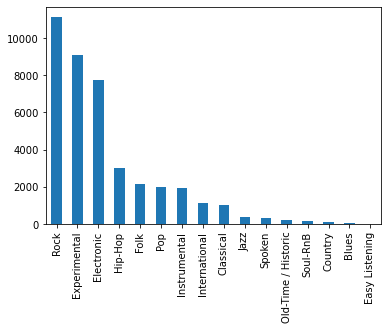

In [124]:
data_lib['track_genre_top'].value_counts().plot.bar()

It is clear that the data is imbalance, that is there are more than 8000 tracks for Rock, Experimental, Electronic, but less than 1000 tracks for Jazz, Old-Time, Soul-RnB, Country, and Blues. There are around 2000-2500 tracks for Hip-Hop, Folk, Pop, Instrumental, and around 1500 tracks for International and Classical.

Let take a look at the correlation between all the averages of the features extracted from Librosa.

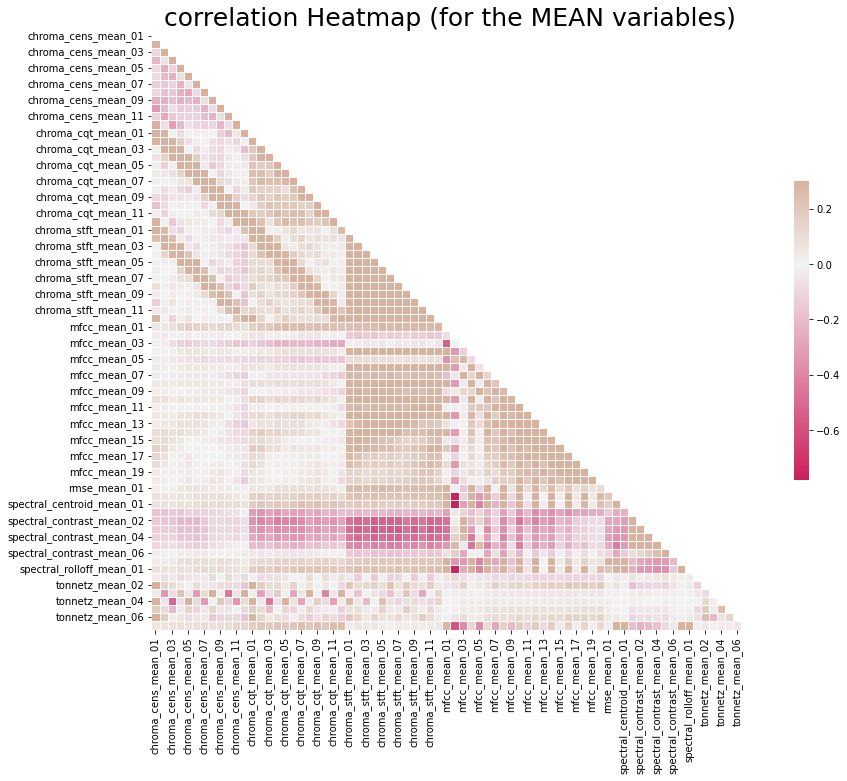

In [127]:
# Computing the Correlation Matrix
spike_cols = [col for col in data_lib.columns if 'mean' in col]
corr = data_lib[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (16,11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap = True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0, square = True, linewidths=0.5, cbar_kws={'shrink':0.5})

plt.title("correlation Heatmap (for the MEAN variables)", fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

Notice that the spectral contrast mean are highly negative correlated to almost all the chroma and mfcc features.

Next, let visualize the genres, but it is very difficult to visual the data with 521 features. So, let us perform the Principal Component Analysis (PCA) and visual the song genres in 2 dimensional space.

In [128]:
from sklearn import preprocessing

data = data_lib.iloc[0:, 1:]
y = data_lib['track_genre_top']
X = data_lib.loc[:,data_lib.columns != 'track_genre_top']

# Normalize X
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# PCA 2 components
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

# Concatenate with target label
finalDF = pd.concat([principalDF, y], axis = 1)

pca.explained_variance_ratio_

array([0.17773399, 0.07916351])

The first two components only make up around 26% of the variance.

Text(0, 0.5, 'PC 2')

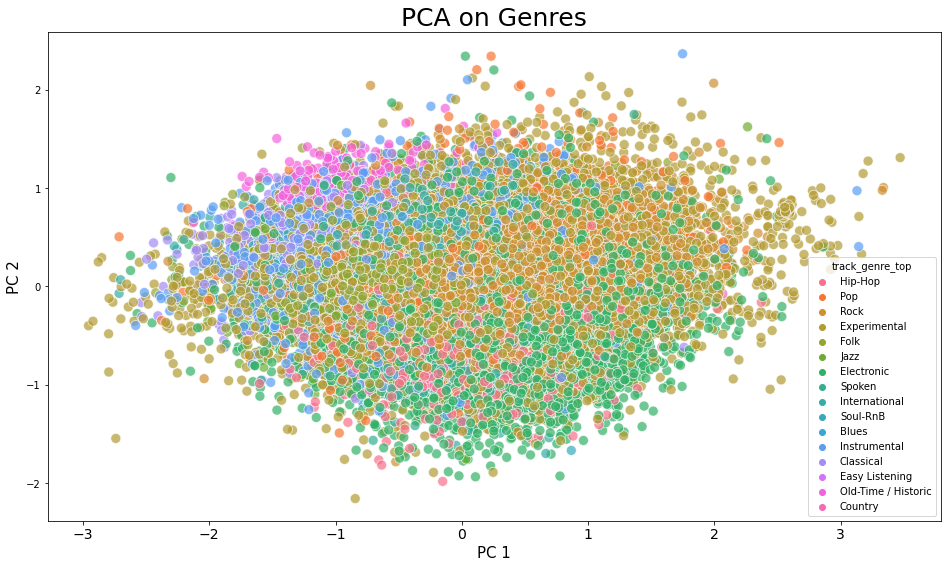

In [129]:
plt.figure(figsize = (16,9))
sns.scatterplot(x = 'PC 1', y = 'PC 2', data = finalDF, hue = 'track_genre_top', alpha = 0.7, s = 100)
plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("PC 1", fontsize = 15)
plt.ylabel("PC 2", fontsize = 15)

There are a lot of noise in the plot above, but we can still see some trend. Almost all the green dots (Jazz, Electronic, Spoken, and International, Soul RnB, Blues) are clustering at the lower end of PC 2 and spread between -2 and 2 for PC 1. Most of the brown, grayish , and orange dots (Rock, Experimental, and Folk) are spreading in the middle region. Purple, light blue and light pink dots (Instrumental, Classical, Old-Time, Easy Listening and Country) are clustering toward the upper left most corner. Light orange (Hip-Hop, Pop) are staying toward the upper right corner.

### Build Model

As we discussed earlier, this is a multi-class classification problem with imbalance dataset. There are 3 approaches that I will take, under-sampling, over-sampling and use tree ensembles (Random Forest, Gradient Boosted Tree, etc.) as tree based model frequently perform well on imbalance data. First, I will remove genres where there are insignificant data such as Jazz, Spoken, Old-Time, Soul-RnB, Countries, Blues, and Easy-Listening. So, we will be working with 9 genres.

Let have an intial look at the model performance before we apply any method to deal with imbalance data.

In [136]:
genre_keep = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental', 'International', 'Classical']
data_librosa = data_lib[data_lib['track_genre_top'].isin(genre_keep)]
print("The shape of the data with 16 genres: ",str(data_lib.shape))
print("The shape of the data with 9 genres: ",str(data_librosa.shape))

The shape of the data with 16 genres:  (91214, 521)
The shape of the data with 9 genres:  (39149, 521)


Take a look at the common statistics for the features extracted from Librosa, we see that the features are in different scale. So, rescaling is necessary before trainning the model.

In [139]:
data_librosa.describe()

,track_duration,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
count,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,...,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000,39149.000000
mean,264.000536,0.257933,0.168939,0.291934,0.147184,0.172328,0.218980,0.232371,0.265350,0.169538,...,0.095426,0.020929,0.021294,27.745911,0.382090,0.054778,0.045682,0.002625,3.077432,0.040718
std,254.918387,7.817161,7.514814,5.805433,1.713857,2.285544,2.344756,11.168215,3.204181,2.267618,...,0.035737,0.005987,0.006036,92.379725,0.185346,0.033155,0.032798,0.005438,2.984923,0.027503
min,0.000000,-1.955806,-1.867213,-1.967450,-1.939882,-1.921206,-1.894519,-1.907819,-1.888697,-3.000000,...,0.010322,0.004619,0.003994,-1.967539,0.017578,0.000239,0.000000,0.000000,-11.464732,0.001392
25%,146.000000,-0.612602,-0.634012,-0.605102,-0.618943,-0.638371,-0.597217,-0.622361,-0.607966,-0.650781,...,0.069243,0.016676,0.017060,3.020371,0.242676,0.034742,0.026367,0.000000,1.307522,0.022320
50%,213.000000,-0.137997,-0.183259,-0.118198,-0.158580,-0.170928,-0.118164,-0.154520,-0.118397,-0.182846,...,0.089995,0.019861,0.020280,9.006861,0.356934,0.049560,0.040039,0.000977,2.303587,0.033506
75%,300.000000,0.545651,0.463812,0.576177,0.494244,0.490415,0.562709,0.520850,0.588428,0.494568,...,0.116433,0.024136,0.024473,25.310204,0.474609,0.066861,0.057129,0.003418,3.921915,0.051739
max,11030.000000,1466.929565,1440.969116,734.007202,108.470627,193.075623,211.774948,2174.952637,361.485748,142.135696,...,0.316604,0.092869,0.101122,8438.014648,0.999512,0.745676,0.895996,0.262207,75.709999,0.424317


In [140]:
y = data_librosa['track_genre_top']
X = data_librosa.loc[:, data.columns !='track_genre_top']

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [145]:
def model_assess(model, title = "Default"):
  model.fit(X_train,y_train)
  preds = model.predict(X_test)
  print('Accuracy', title, ':', round(accuracy_score(y_test,preds),5),'\n')

In [ ]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")


Accuracy Naive Bayes : 0.18782 

Accuracy Stochastic Gradient Descent : 0.62784 

Accuracy KNN : 0.58416 

Accuracy Decission trees : 0.47314 

Accuracy Random Forest : 0.61286 

Accuracy Support Vector Machine : 0.64828 

Accuracy Logistic Regression : 0.62554 

Accuracy Neural Nets : 0.60562 

[14:57:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Over-Sampling

## Combine All Features

In [84]:
from functools import reduce

# compile the list of dataframes you want to merge
data_frames = [tracks_features_of_interest, echonest_features_of_interest, features]
data = reduce(lambda  left,right: pd.merge(left,right,on=['track_id'],
                                            how='inner'), data_frames)
print("The shape of the combined data: ",str(data.shape))

The shape of the combined data:  (7307, 530)


In [93]:
data = data.dropna(subset=['track_genre_top'])
print("The shape of the data after dropping empty values in genre column: ", str(data.shape))

The shape of the data after dropping empty values in genre column:  (4743, 530)


<AxesSubplot:>

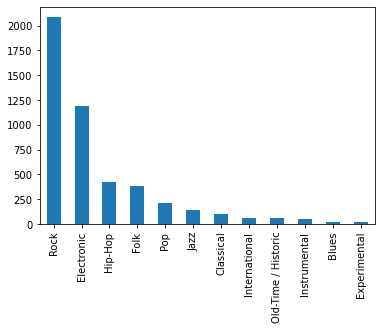

In [94]:
data['track_genre_top'].value_counts().plot.bar()

There is a problem of imbalance among the genre, where Rocks have the most tracks with the features of interest, and Blues have the least tracks.